# Deploy and monitor a machine learning workflow for Image Classification

## Setting up this notebook

Notes about the instance size and kernel setup: this notebook has been tested on

1. The `Python 3 (Data Science)` kernel
2. The `ml.t3.medium` Sagemaker notebook instance

## Data Staging

We'll use a sample dataset called CIFAR. In order to start working with CIFAR we'll need to:

1. Extract the data from a hosting service
2. Transform it into a usable shape and format
3. Load it into a production system


### 1. Extract the data from the hosting service

In the cell below, define a function `extract_cifar_data` that extracts python version of the CIFAR-100 dataset. The CIFAR dataaset is open source and generously hosted by the University of Toronto at: https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz

In [ ]:
import requests

def extract_cifar_data(url, filename="cifar.tar.gz"):
    """A function for extracting the CIFAR-100 dataset and storing it as a gzipped file

    Arguments:
    url      -- the URL where the dataset is hosted
    filename -- the full path where the dataset will be written

    """

    r = requests.get(url)
    with open(filename, "wb") as file_context:
        file_context.write(r.content)
    return

Let's test it out! Run the following cell and check whether a new file `cifar.tar.gz` is created in the file explorer.

In [ ]:
extract_cifar_data("https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz")

### 2. Transform the data into a usable shape and format

Clearly, distributing the data as a gzipped archive makes sense for the hosting service! It saves on bandwidth, storage, and it's a widely-used archive format. In fact, it's so widely used that the Python community ships a utility for working with them, `tarfile`, as part of its Standard Library. Execute the following cell to decompress your extracted dataset:

In [ ]:
import tarfile

with tarfile.open("cifar.tar.gz", "r:gz") as tar:
    tar.extractall()

A new folder `cifar-100-python` should be created, containing `meta`, `test`, and `train` files. These files are `pickles` and the [CIFAR homepage](https://www.cs.toronto.edu/~kriz/cifar.html) provides a simple script that can be used to load them. We've adapted the script below for you to run:

In [ ]:
import pickle

with open("./cifar-100-python/meta", "rb") as f:
    dataset_meta = pickle.load(f, encoding='bytes')

with open("./cifar-100-python/test", "rb") as f:
    dataset_test = pickle.load(f, encoding='bytes')

with open("./cifar-100-python/train", "rb") as f:
    dataset_train = pickle.load(f, encoding='bytes')

In [ ]:
dataset_train.keys()

As documented on the homepage, `b'data'` contains rows of 3073 unsigned integers, representing three channels (red, green, and blue) for one 32x32 pixel image per row.

In [ ]:
32*32*3

3072

For a simple gut-check, let's transform one of our images. Each 1024 items in a row is a channel (red, green, then blue). Each 32 items in the channel are a row in the 32x32 image. Using python, we can stack these channels into a 32x32x3 array, and save it as a PNG file:

In [ ]:
import numpy as np

# Each 1024 in a row is a channel (red, green, then blue)
row = dataset_train[b'data'][0]
red, green, blue = row[0:1024], row[1024:2048], row[2048:]

# Each 32 items in the channel are a row in the 32x32 image
red = red.reshape(32,32)
green = green.reshape(32,32)
blue = blue.reshape(32,32)

# Combine the channels into a 32x32x3 image!
combined = np.dstack((red,green,blue))

For a more concise version, consider the following:

In [ ]:
# All in one:
test_image = np.dstack((
    row[0:1024].reshape(32,32),
    row[1024:2048].reshape(32,32),
    row[2048:].reshape(32,32)
))

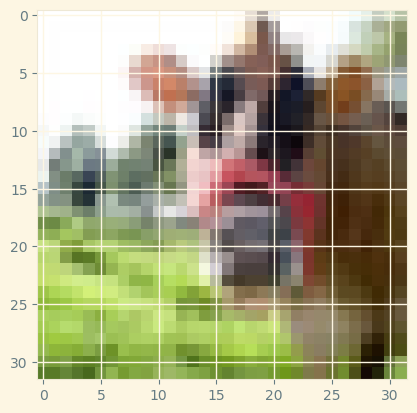

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(test_image);

Looks like a cow! Let's check the label. `dataset_meta` contains label names in order, and `dataset_train` has a list of labels for each row.

In [ ]:
dataset_train[b'fine_labels'][0]

19

Our image has a label of `19`, so let's see what the 19th item is in the list of label names.

In [ ]:
print(dataset_meta[b'fine_label_names'][19])

b'cattle'


Ok! 'cattle' sounds about right. By the way, using the previous two lines we can do:

In [ ]:
n = 0
print(dataset_meta[b'fine_label_names'][dataset_train[b'fine_labels'][n]])

b'cattle'


Now we know how to check labels, is there a way that we can also check file names? `dataset_train` also contains a `b'filenames'` key. Let's see what we have here:

In [ ]:
print(dataset_train[b'filenames'][0])

b'bos_taurus_s_000507.png'


"Taurus" is the name of a subspecies of cattle, so this looks like a pretty reasonable filename. To save an image we can also do:

In [ ]:
plt.imsave("file.png", test_image)

Your new PNG file should now appear in the file explorer -- go ahead and pop it open to see!

Now that you know how to reshape the images, save them as files, and capture their filenames and labels, let's just capture all the bicycles and motorcycles and save them.

In the following cell, identify the label numbers for Bicycles and Motorcycles:

In [ ]:
import pandas as pd

# Define the label names for Bicycles and Motorcycles
target_labels = ["bicycle", "motorcycle"]

# Find the label numbers for Bicycles and Motorcycles
label_numbers = []
for label_num, label_name in enumerate(dataset_meta[b'fine_label_names']):
    decoded_label_name = label_name.decode("utf-8")
    if decoded_label_name in target_labels:
        label_numbers.append(label_num)

# Print the label numbers for Bicycles and Motorcycles
print("Label Numbers:")
for label_name, label_num in zip(target_labels, label_numbers):
    print(f"{label_name}: {label_num}")


Label Numbers:
bicycle: 8
motorcycle: 48


Good job! We only need objects with label 8 and 48 -- this drastically simplifies our handling of the data! Below we construct a dataframe for you, and you can safely drop the rows that don't contain observations about bicycles and motorcycles. Fill in the missing lines below to drop all other rows:

In [ ]:
#Construct the dataframe
df_train = pd.DataFrame({
    "filenames": dataset_train[b'filenames'],
    "labels": dataset_train[b'fine_labels'],
    "row": range(len(dataset_train[b'filenames']))
})

# Drop all rows from df_train where label is not 8 or 48
df_train = df_train[df_train["labels"].isin([8, 48])]

# Decode df_train.filenames so they are regular strings
df_train["filenames"] = df_train["filenames"].apply(
    lambda x: x.decode("utf-8")
)


df_test = pd.DataFrame({
    "filenames": dataset_test[b'filenames'],
    "labels": dataset_test[b'fine_labels'],
    "row": range(len(dataset_test[b'filenames']))
})

# Drop all rows from df_test where label is not 8 or 48
df_test = df_test[df_test["labels"].isin([8, 48])]

# Decode df_test.filenames so they are regular strings
df_test["filenames"] = df_test["filenames"].apply(
    lambda x: x.decode("utf-8")
)

Now that the data is filtered for just our classes, we can save all our images.

In [ ]:
!mkdir ./train
!mkdir ./test


Compose these together into a function that saves all the images into the `./test` and `./train` directories.


In [ ]:
def save_images(dataset,row,directory):
    #Grab the image data in row-major form
    img = dataset[b'data'][row]

    # Consolidated stacking/reshaping from earlier
    target = np.dstack((
    img[0:1024].reshape(32,32),
    img[1024:2048].reshape(32,32),
    img[2048:].reshape(32,32)
    ))

    # Save the image
    plt.imsave(directory, target)

    # Return any signal data you want for debugging
    return
for index, row in df_train.iterrows():
    save_images(dataset_train,row["row"],"train/"+row["filenames"])
for index, row in df_test.iterrows():
    save_images(dataset_test,row["row"],"test/"+row["filenames"])

### 3. Load the data

Now we can load the data into S3.

Using the sagemaker SDK grab the current region, execution role, and bucket.

In [ ]:
import sagemaker
import boto3


bucket = "sagemaker-studio-qoiwf6trndq"

# Print the bucket name
print("Default Bucket: {}".format(bucket))

# Get the AWS region
region = boto3.Session().region_name

# Print the AWS region
print("AWS Region: {}".format(region))

# Get the IAM role ARN
role = sagemaker.get_execution_role()

# Print the IAM role ARN
print("RoleArn: {}".format(role))

Default Bucket: sagemaker-studio-qoiwf6trndq
AWS Region: us-east-1
RoleArn: arn:aws:iam::498048198264:role/service-role/AmazonSageMaker-ExecutionRole-20230821T160023


With this data we can easily sync your data up into S3!

In [ ]:
import os

os.environ["DEFAULT_S3_BUCKET"] = bucket
!aws s3 sync ./train s3://${DEFAULT_S3_BUCKET}/train/
!aws s3 sync ./test s3://${DEFAULT_S3_BUCKET}/test/

And that's it! You can check the bucket and verify that the items were uploaded.

## Model Training

For Image Classification, Sagemaker [also expects metadata](https://docs.aws.amazon.com/sagemaker/latest/dg/image-classification.html) e.g. in the form of TSV files with labels and filepaths. We can generate these using our Pandas DataFrames from earlier:

In [ ]:
def to_metadata_file(df, prefix):
    df["s3_path"] = df["filenames"]
    df["labels"] = df["labels"].apply(lambda x: 0 if x==8 else 1)
    return df[["row", "labels", "s3_path"]].to_csv(
        f"{prefix}.lst", sep="\t", index=False, header=False
    )

to_metadata_file(df_train.copy(), "train")
to_metadata_file(df_test.copy(), "test")

We can also upload our manifest files:

In [ ]:
import boto3

# Upload files
boto3.Session().resource('s3').Bucket(
    bucket).Object('train.lst').upload_file('./train.lst')
boto3.Session().resource('s3').Bucket(
    bucket).Object('test.lst').upload_file('./test.lst')

Using the `bucket` and `region` info we can get the latest prebuilt container to run our training job, and define an output location on our s3 bucket for the model. Use the `image_uris` function from the SageMaker SDK to retrieve the latest `image-classification` image below:

In [ ]:
# Use the image_uris function to retrieve the latest 'image-classification' image
algo_image =sagemaker.image_uris.retrieve("image-classification", region)
s3_output_location = f"s3://{bucket}/models/image_model"

We're ready to create an estimator! Create an estimator `img_classifier_model` that uses one instance of `ml.p3.2xlarge`.

In [ ]:
img_classifier_model=sagemaker.estimator.Estimator(
    image_uri=algo_image,
    instance_type="ml.p3.2xlarge",
    instance_count=1,
    role=sagemaker.get_execution_role(),
    output_path=s3_output_location,
    sagemaker_session=sagemaker.Session()
)

We can also set a few key hyperparameters and define the inputs for our model:

In [ ]:
img_classifier_model.set_hyperparameters(
    image_shape="3,32,32",  # Image shape: channels, height, width
    num_classes=2,  # Number of classes (binary classification in this case)
    num_training_samples=len(df_train)  # Total number of training samples
)

The `image-classification` image uses four input channels with very specific input parameters. For convenience, we've provided them below:

In [ ]:
from sagemaker.debugger import Rule, rule_configs
from sagemaker.session import TrainingInput
model_inputs = {
        "train": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/train/",
            content_type="application/x-image"
        ),
        "validation": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/test/",
            content_type="application/x-image"
        ),
        "train_lst": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/train.lst",
            content_type="application/x-image"
        ),
        "validation_lst": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/test.lst",
            content_type="application/x-image"
        )
}

Great, now we can train the model using the model_inputs.

In [ ]:
img_classifier_model.fit(inputs=model_inputs)


INFO:sagemaker:Creating training-job with name: image-classification-2023-08-22-22-42-55-319


2023-08-22 22:42:55 Starting - Starting the training job......
2023-08-22 22:43:29 Starting - Preparing the instances for training......
2023-08-22 22:44:33 Downloading - Downloading input data...
2023-08-22 22:44:58 Training - Downloading the training image..................
2023-08-22 22:48:04 Training - Training image download completed. Training in progress...Docker entrypoint called with argument(s): train
Running default environment configuration script
Nvidia gpu devices, drivers and cuda toolkit versions (only available on hosts with GPU):
Tue Aug 22 22:48:32 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.54.03              Driver Version: 535.54.03    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Me

you'll end up with a model topping out above `.8` validation accuracy. With only 1000 training samples in the CIFAR dataset, that's pretty good.

### Getting ready to deploy

To begin with, let's configure Model Monitor to track our deployment. We'll define a `DataCaptureConfig` below:

In [ ]:
from sagemaker.model_monitor import DataCaptureConfig

data_capture_config = DataCaptureConfig(
    enable_capture=True,  # Enable data capture
    sampling_percentage=100,  # Percentage of requests to capture
    destination_s3_uri=f"s3://{bucket}/data_capture"  # S3 location to store captured data
)

Note the `destination_s3_uri` parameter: At the end of the project, we can explore the `data_capture` directory in S3 to find crucial data about the inputs and outputs Model Monitor has observed on our model endpoint over time.

With that done, deploy your model on a single `ml.m5.xlarge` instance with the data capture config attached:

In [ ]:
deployment = img_classifier_model.deploy(
    initial_instance_count=1,  # Number of instances
    instance_type="ml.m5.xlarge",  # Instance type
    data_capture_config=data_capture_config  # Attach data capture config
)
endpoint = deployment.endpoint_name
print(endpoint)

INFO:sagemaker:Creating model with name: image-classification-2023-08-22-22-52-59-515
INFO:sagemaker:Creating endpoint-config with name image-classification-2023-08-22-22-52-59-515
INFO:sagemaker:Creating endpoint with name image-classification-2023-08-22-22-52-59-515


--------------!image-classification-2023-08-22-22-52-59-515


Note the endpoint name for later as well.

Next, instantiate a Predictor:

In [ ]:
print(deployment)
predictor = sagemaker.predictor.RealTimePredictor(
    endpoint=deployment.endpoint_name,
    endpoint_name="image-classification-2023-08-22-22-52-59-515",
    sagemaker_session=sagemaker.Session()
)

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Predictor: {'endpoint_name': 'image-classification-2023-08-22-22-52-59-515', 'sagemaker_session': <sagemaker.session.Session object at 0x7f4f6baaf710>, 'serializer': <sagemaker.base_serializers.IdentitySerializer object at 0x7f4f83979f10>, 'deserializer': <sagemaker.base_deserializers.BytesDeserializer object at 0x7f4f839810d0>}


In the code snippet below we are going to prepare one of your saved images for prediction. Use the predictor to process the `payload`.

In [ ]:
from sagemaker.serializers import IdentitySerializer
import base64

predictor.serializer = IdentitySerializer("image/png")
with open("./test/bicycle_s_001789.png", "rb") as f:
    payload = f.read()


inference = predictor.predict(payload)

Your `inference` object is an array of two values, the predicted probability value for each of your classes (bicycle and motorcycle respectively.) So, for example, a value of `b'[0.91, 0.09]'` indicates the probability of being a bike is 91% and being a motorcycle is 9%.

In [ ]:
print(inference)

b'[0.990204930305481, 0.009795118123292923]'



### Testing and Evaluation

Do several step function invokations using data from the `./test` folder. This process should give you confidence that the workflow both *succeeds* AND *fails* as expected. In addition, SageMaker Model Monitor will generate recordings of your data and inferences which we can visualize.

Here's a function that can help you generate test inputs for your invokations:

In [ ]:
import random
import boto3
import json


def generate_test_case():
    # Setup s3 in boto3
    s3 = boto3.resource('s3')

    # Randomly pick from sfn or test folders in our bucket
    objects = s3.Bucket(bucket).objects.filter(Prefix="test/")

    # Grab any random object key from that folder!
    obj = random.choice([x.key for x in objects])

    return json.dumps({
        "image_data": "",
        "s3_bucket": bucket,
        "s3_key": obj
    })
generate_test_case()

'{"image_data": "", "s3_bucket": "sagemaker-studio-qoiwf6trndq", "s3_key": "test/minibike_s_001867.png"}'

In the Step Function dashboard for your new function, you can create new executions and copy in the generated test cases. Do several executions so that you can generate data you can evaluate and visualize.

Once you've done several executions, let's visualize the record of our inferences. Pull in the JSONLines data from your inferences like so:

In [ ]:
from sagemaker.s3 import S3Downloader

# In S3 your data will be saved to a datetime-aware path
# Find a path related to a datetime you're interested in
data_path = "s3://sagemaker-studio-qoiwf6trndq/data_capture/image-classification-2023-08-22-22-52-59-515/AllTraffic/2023/08/22/23/"

S3Downloader.download(data_path, "captured_data")


['captured_data/00-33-391-3dc15cb9-120a-47d2-9ad8-ec9d33d5d06a.jsonl',
 'captured_data/01-38-447-f053e662-baf7-4c50-9029-5e988d37eb77.jsonl',
 'captured_data/02-42-169-f10c52aa-61f0-4631-8a6d-e9bc61b30096.jsonl',
 'captured_data/03-43-129-ffbec3c4-ac41-4fa8-818c-7e9ce2d48b58.jsonl',
 'captured_data/04-53-864-4fc8acbc-75f6-448c-8332-2fb8a7e14a7d.jsonl',
 'captured_data/06-01-813-0a5634b6-09bc-4904-870e-5d2f1b55a8f9.jsonl',
 'captured_data/07-22-968-6d52c321-1ad9-47c2-a3e9-1c286d7d95ea.jsonl']

The data are in JSONLines format, where multiple valid JSON objects are stacked on top of eachother in a single `jsonl` file. We'll import an open-source library, `jsonlines` that was purpose built for parsing this format.

In [ ]:
!pip install jsonlines
import jsonlines

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


Now we can extract the data from each of the source files:

In [ ]:
import os

# List the file names we downloaded
file_handles = os.listdir("./captured_data")

# Dump all the data into an array
json_data = []
for jsonl in file_handles:
    with jsonlines.open(f"./captured_data/{jsonl}") as f:
        json_data.append(f.read())


The data should now be a list of dictionaries, with significant nesting. We'll give you an example of some code that grabs data out of the objects and visualizes it:

In [ ]:
# Define how we'll get our data
def simple_getter(obj):
    inferences = obj["captureData"]["endpointOutput"]["data"]
    timestamp = obj["eventMetadata"]["inferenceTime"]
    return json.loads(inferences), timestamp

simple_getter(json_data[0])

([0.990204930305481, 0.009795118123292923], '2023-08-22T23:00:33Z')

Finally, here's an example of a visualization.

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


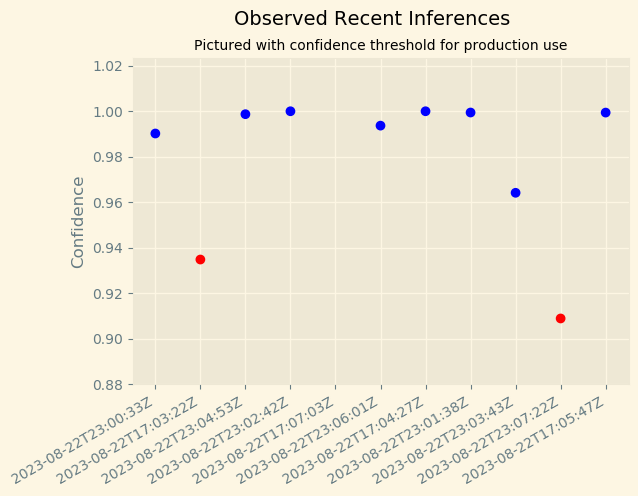

In [ ]:
# Populate the data for the x and y axis
%matplotlib inline
import json
x = []
y = []
for obj in json_data:
    inference, timestamp = simple_getter(obj)

    y.append(max(inference))
    x.append(timestamp)

# Plot the data
plt.scatter(x, y, c=['r' if k<.94 else 'b' for k in y ])
plt.axhline(y=0.7, color='g', linestyle='--')
plt.ylim(bottom=.88)

# Add labels
plt.ylabel("Confidence")
plt.suptitle("Observed Recent Inferences", size=14)
plt.title("Pictured with confidence threshold for production use", size=10)

# Give it some pizzaz!
plt.style.use("Solarize_Light2")
plt.gcf().autofmt_xdate()

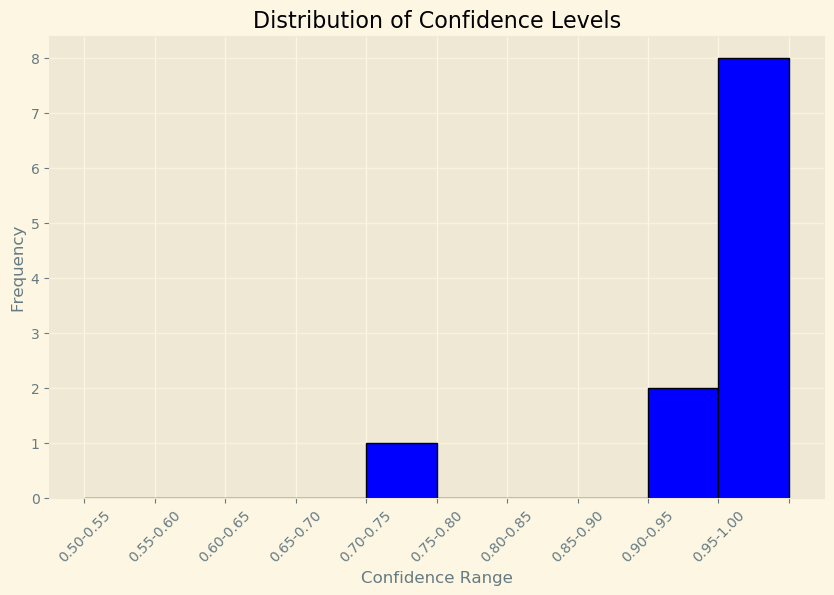

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Define bins for different confidence ranges
bins = np.arange(0.5, 1.01, 0.05)
bin_labels = [f"{b:.2f}-{b+0.05:.2f}" for b in bins[:-1]]

# Create histogram of confidence levels
plt.figure(figsize=(10, 6))
plt.hist(y, bins=bins, color='blue', edgecolor='black')

# Customize labels and title
plt.xlabel('Confidence Range')
plt.ylabel('Frequency')
plt.title('Distribution of Confidence Levels')
plt.xticks(bins, bin_labels, rotation=45)
plt.grid(axis='y', alpha=0.75)

# Display plot
plt.show()
